<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/8.29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Multi-armed Bandits

This lab explores the multi-armed bandit problem, where an agent must choose among multiple options (arms) with unknown reward distributions to maximize its cumulative reward over time.

In [1]:
%pylab inline
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Number of bandit arms
K = 5 # @param {"type":"integer"}
# Number of trials (time steps)
T = 100  # @param {"type":"integer"}

# Random seed
seed = 0

Text(0.5, 1.02, 'Unknown Reward Distributions for K Bandits')

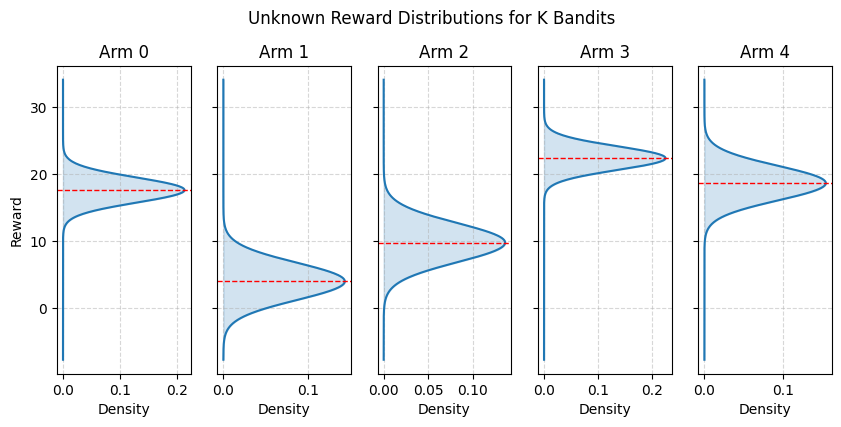

In [3]:
# Stattionary probability distribution for K bandits
np.random.seed(seed)
bandit_mean = 10 * np.random.normal(size=K)
bandit_std = np.random.uniform(1, 3, size=K)




###### Plot disttributions #######
fig, axes = plt.subplots(1, K, figsize=(2*K, 4), sharey=True)

x_min = bandit_mean.min() - 4 * bandit_std.max()
x_max = bandit_mean.max() + 4 * bandit_std.max()
x = np.linspace(x_min, x_max, 500)

for i, ax in enumerate(axes):
    y = norm.pdf(x, loc=bandit_mean[i], scale=bandit_std[i])
    ax.plot(y, x, color="C0")  # vertical orientation
    ax.fill_betweenx(x, 0, y, alpha=0.2, color="C0")
    ax.axhline(bandit_mean[i], color="r", linestyle="--", linewidth=1)  # mean
    ax.set_title(f"Arm {i}")
    ax.set_xlabel("Density")
    if i == 0:
        ax.set_ylabel("Reward")
    ax.grid(True, linestyle="--", alpha=0.5)
plt.suptitle("Unknown Reward Distributions for K Bandits", y=1.02)


Text(0, 0.5, 'Reward')

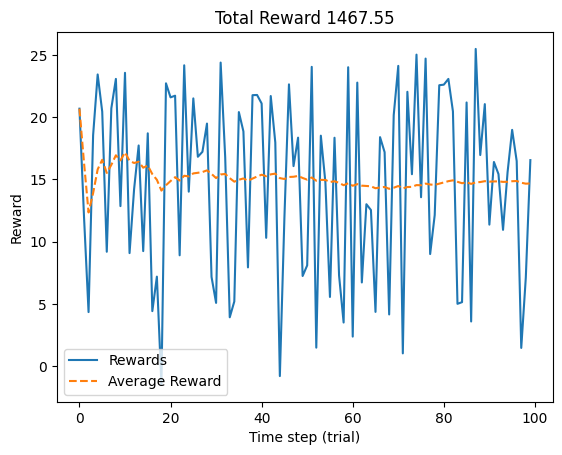

In [4]:
# Rewards
rewards = []

# For T trials, chose a random arm
for t in range(T):
  # Action: Choose a random arm
  a = np.random.randint(0, K-1)

  # Reward
  r = np.random.normal(bandit_mean[a], bandit_std[a])
  rewards.append(r)


# Total reward
total = sum(rewards)
avg_reward = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)

# Plot results
plot(rewards, label='Rewards')
plot(avg_reward, '--', label='Average Reward')
legend()
title("Rewards")
plt.title("Total Reward %.2f"%total)
xlabel("Time step (trial)")
ylabel("Reward")




## Exercise 1: Implement Your Own Bandit Policy

In the previous cells, we simulated a multi-armed bandit problem and observed the rewards obtained by choosing arms randomly. While this gives us a baseline, a random policy is unlikely to be the most effective way to maximize rewards.

Your task is to implement your own policy for selecting which bandit arm to pull at each time step `t`. The total reward should be higher than the

Policy: thompson_nig


Text(0, 0.5, 'Reward')

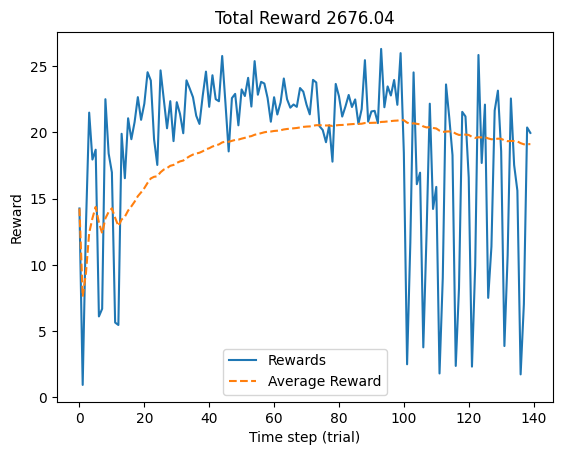

In [16]:
import numpy as np
POLICY = "thompson_nig"   # "random" | "greedy" | "epsilon_greedy" | "thompson_nig"
EPS    = 0.1        # for epsilon_greedy

n    = np.zeros(K, dtype=int)     # pulls per arm
mean = np.zeros(K, dtype=float)   # running mean
M2   = np.zeros(K, dtype=float)   # sum of squared deviations


# -------------------------------
# update mean & variance
# -------------------------------
def welford_update(i: int, x: float) -> None:
    n[i] += 1
    d = x - mean[i]
    mean[i] += d / n[i]
    d2 = x - mean[i]
    M2[i] += d * d2

# -------------------------------
# Thompson Sampling (Normal–Inverse-Gamma posterior)
# mean & variance both unknown
# -------------------------------
mu0, kappa0, alpha0, beta0 = 0.0, 1e-6, 1e-6, 1e-6

def nig_posterior_params(i: int):
    if n[i] == 0:
        return mu0, kappa0, alpha0, beta0
    xbar, S, ni = mean[i], M2[i], n[i]
    kappa_n = kappa0 + ni
    mu_n    = (kappa0 * mu0 + ni * xbar) / kappa_n
    alpha_n = alpha0 + 0.5 * ni
    beta_n  = beta0 + 0.5 * S + (kappa0 * ni * (xbar - mu0)**2) / (2.0 * kappa_n)
    return mu_n, kappa_n, alpha_n, beta_n

def thompson_nig_select() -> int:
    sampled = np.empty(K)
    for i in range(K):
        mu_n, kappa_n, a_n, b_n = nig_posterior_params(i)
        sigma2 = b_n / np.random.gamma(shape=a_n, scale=1.0)       # Inv-Gamma
        mu_draw = np.random.normal(mu_n, np.sqrt(sigma2 / kappa_n)) # Normal
        sampled[i] = mu_draw
    return int(np.argmax(sampled))

# -------------------------------
# Policy router
# -------------------------------
def select_arm(policy: str) -> int:
    if policy == "random":
        return np.random.randint(0, K)
    elif policy == "greedy":
        return int(np.argmax(mean))
    elif policy == "epsilon_greedy":
        return np.random.randint(0, K) if np.random.rand() < EPS else int(np.argmax(mean))
    elif policy == "thompson_nig":
        return thompson_nig_select()
    else:
        raise ValueError(f"Unknown policy: {policy}")


# Warm-up
for i in range(K):
    r0 = np.random.normal(bandit_mean[i], bandit_std[i])
    welford_update(i, r0)
    rewards.append(r0)


for t in range(len(rewards), T):
    a = select_arm(POLICY)
    r = np.random.normal(bandit_mean[a], bandit_std[a])
    welford_update(a, r)
    rewards.append(r)

# Total reward
total = sum(rewards)
avg_reward = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)

# Plot results
print(f"Policy: {POLICY}")
plot(rewards, label='Rewards')
plot(avg_reward, '--', label='Average Reward')
legend()
title("Rewards")
plt.title("Total Reward %.2f"%total)
xlabel("Time step (trial)")
ylabel("Reward")

## Exercise 2: Greedy strategy


1. Implement the greedy strategy: Always choose the arm with the highest estimated average reward.

2. Implement the Epsilon-greedy strategy: with a small probability epsilon, choose a random arm; otherwise, choose the greedy arm.

3. [Optional for 337] Implement Thompson Sampling: Maintain a probability distribution over the expected reward for each arm and sample from these distributions to choose an arm.



# Questions
After compleing the excercises, answer the following questions:

1. In the epsilon-greedy strategy, compare ε = 0.1 and ε = 0.001. What are the advantages of using a larger ε?
2. If the reward distribution changes smoothly over time, is a purely greedy strategy still effective?
3. How does the choice of ε affect the balance between exploration and exploitation in the long run?  
4. Suppose the number of arms increases significantly. How might this change the effectiveness of the epsilon-greedy strategy?  